<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=aff9894ab51594b5c714526ed29acf7dc4c4d6427b30a6de889b85166776ceb9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=33f5cd984382ebb1d9ffdb0830c422ba0168cb71cb76bb1049b123da91844341
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 18.8MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [4]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 50
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [5]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [6]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [ ]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [ ]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


#6. Training and testing

In [10]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.2
    #elif 50 <= epoch < 70:
        #return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

from segmentation_models_pytorch.losses import FocalLoss

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0, weight_focal=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = weight_dice
        self.bce_weight = weight_bce
        self.focal_weight = weight_focal
        self.focal_loss = FocalLoss(mode='binary')

    def forward(self, outputs, targets):
        # Ensure outputs and targets have the same shape
        assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"

        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        focal_loss = self.focal_loss(outputs, targets)

        total_loss = (self.bce_weight * bce_loss +
                      self.dice_weight * dice_loss +
                      self.focal_weight * focal_loss)
        return total_loss

# Instantiate the criterion
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0, weight_focal=5.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [11]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 1/50, Training Loss: 1.5355


Epoch 1/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 1/50, Validation Loss: 1.5948
Precision: 0.0000, Recall: 0.0000, Accuracy: 0.6799
IoU: 0.0000, F1 Score: 0.0000, Dice Coefficient: 0.0000
Pixel Error: 0.3201, Rand Error: 1.0000


Epoch 2/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 2/50, Training Loss: 1.4183


Epoch 2/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 2/50, Validation Loss: 1.4676
Precision: 0.9315, Recall: 0.7629, Accuracy: 0.9061
IoU: 0.7286, F1 Score: 0.8388, Dice Coefficient: 0.8413
Pixel Error: 0.0939, Rand Error: 0.3457


Epoch 3/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch 3/50, Training Loss: 1.1723


Epoch 3/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 3/50, Validation Loss: 1.1068
Precision: 0.8924, Recall: 0.9062, Accuracy: 0.9350
IoU: 0.8191, F1 Score: 0.8992, Dice Coefficient: 0.8995
Pixel Error: 0.0650, Rand Error: 0.2470


Epoch 4/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 4/50, Training Loss: 1.0159


Epoch 4/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 4/50, Validation Loss: 0.9374
Precision: 0.9306, Recall: 0.9354, Accuracy: 0.9570
IoU: 0.8720, F1 Score: 0.9330, Dice Coefficient: 0.9310
Pixel Error: 0.0430, Rand Error: 0.1688


Epoch 5/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 5/50, Training Loss: 0.8934


Epoch 5/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 5/50, Validation Loss: 0.8175
Precision: 0.8976, Recall: 0.9719, Accuracy: 0.9555
IoU: 0.8749, F1 Score: 0.9333, Dice Coefficient: 0.9331
Pixel Error: 0.0445, Rand Error: 0.1732


Epoch 6/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 6/50, Training Loss: 0.7944


Epoch 6/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 6/50, Validation Loss: 0.7521
Precision: 0.8341, Recall: 0.9895, Accuracy: 0.9336
IoU: 0.8232, F1 Score: 0.9052, Dice Coefficient: 0.9028
Pixel Error: 0.0664, Rand Error: 0.2520


Epoch 7/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 7/50, Training Loss: 0.7152


Epoch 7/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 7/50, Validation Loss: 0.7406
Precision: 0.9287, Recall: 0.9336, Accuracy: 0.9558
IoU: 0.8725, F1 Score: 0.9311, Dice Coefficient: 0.9315
Pixel Error: 0.0442, Rand Error: 0.1722


Epoch 8/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 8/50, Training Loss: 0.6199


Epoch 8/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 8/50, Validation Loss: 0.6531
Precision: 0.9472, Recall: 0.9471, Accuracy: 0.9662
IoU: 0.8982, F1 Score: 0.9471, Dice Coefficient: 0.9460
Pixel Error: 0.0338, Rand Error: 0.1346


Epoch 9/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 9/50, Training Loss: 0.5573


Epoch 9/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 9/50, Validation Loss: 0.6319
Precision: 0.9417, Recall: 0.9554, Accuracy: 0.9668
IoU: 0.9044, F1 Score: 0.9485, Dice Coefficient: 0.9495
Pixel Error: 0.0332, Rand Error: 0.1305


Epoch 10/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 10/50, Training Loss: 0.5037


Epoch 10/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 10/50, Validation Loss: 0.5678
Precision: 0.9317, Recall: 0.9764, Accuracy: 0.9695
IoU: 0.9102, F1 Score: 0.9535, Dice Coefficient: 0.9528
Pixel Error: 0.0305, Rand Error: 0.1210


Epoch 11/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 11/50, Training Loss: 0.4811


Epoch 11/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 11/50, Validation Loss: 0.5426
Precision: 0.9692, Recall: 0.9265, Accuracy: 0.9671
IoU: 0.8983, F1 Score: 0.9474, Dice Coefficient: 0.9461
Pixel Error: 0.0329, Rand Error: 0.1316


Epoch 12/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 12/50, Training Loss: 0.4612


Epoch 12/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 12/50, Validation Loss: 0.5402
Precision: 0.9234, Recall: 0.9600, Accuracy: 0.9617
IoU: 0.8902, F1 Score: 0.9414, Dice Coefficient: 0.9417
Pixel Error: 0.0383, Rand Error: 0.1497


Epoch 13/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 13/50, Training Loss: 0.4482


Epoch 13/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 13/50, Validation Loss: 0.5210
Precision: 0.9232, Recall: 0.9404, Accuracy: 0.9559
IoU: 0.8698, F1 Score: 0.9317, Dice Coefficient: 0.9302
Pixel Error: 0.0441, Rand Error: 0.1733


Epoch 14/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 14/50, Training Loss: 0.4238


Epoch 14/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 14/50, Validation Loss: 0.4682
Precision: 0.9379, Recall: 0.9543, Accuracy: 0.9652
IoU: 0.9000, F1 Score: 0.9460, Dice Coefficient: 0.9470
Pixel Error: 0.0348, Rand Error: 0.1360


Epoch 15/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 15/50, Training Loss: 0.3864


Epoch 15/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 15/50, Validation Loss: 0.4507
Precision: 0.9563, Recall: 0.9601, Accuracy: 0.9732
IoU: 0.9202, F1 Score: 0.9582, Dice Coefficient: 0.9582
Pixel Error: 0.0268, Rand Error: 0.1063


Epoch 16/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 16/50, Training Loss: 0.3582


Epoch 16/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 16/50, Validation Loss: 0.4476
Precision: 0.9589, Recall: 0.9601, Accuracy: 0.9740
IoU: 0.9221, F1 Score: 0.9595, Dice Coefficient: 0.9592
Pixel Error: 0.0260, Rand Error: 0.1031


Epoch 17/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 17/50, Training Loss: 0.3400


Epoch 17/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 17/50, Validation Loss: 0.4187
Precision: 0.9349, Recall: 0.9821, Accuracy: 0.9724
IoU: 0.9185, F1 Score: 0.9579, Dice Coefficient: 0.9573
Pixel Error: 0.0276, Rand Error: 0.1096


Epoch 18/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 18/50, Training Loss: 0.3492


Epoch 18/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 18/50, Validation Loss: 0.4628
Precision: 0.9416, Recall: 0.9442, Accuracy: 0.9634
IoU: 0.8905, F1 Score: 0.9429, Dice Coefficient: 0.9418
Pixel Error: 0.0366, Rand Error: 0.1441


Epoch 19/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 19/50, Training Loss: 0.3280


Epoch 19/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 19/50, Validation Loss: 0.4381
Precision: 0.9663, Recall: 0.9391, Accuracy: 0.9700
IoU: 0.9043, F1 Score: 0.9525, Dice Coefficient: 0.9494
Pixel Error: 0.0300, Rand Error: 0.1208


Epoch 20/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 20/50, Training Loss: 0.3100


Epoch 20/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 20/50, Validation Loss: 0.4353
Precision: 0.9295, Recall: 0.9654, Accuracy: 0.9655
IoU: 0.8993, F1 Score: 0.9471, Dice Coefficient: 0.9467
Pixel Error: 0.0345, Rand Error: 0.1354


Epoch 21/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 21/50, Training Loss: 0.3050


Epoch 21/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 21/50, Validation Loss: 0.4213
Precision: 0.9600, Recall: 0.9460, Accuracy: 0.9701
IoU: 0.9086, F1 Score: 0.9529, Dice Coefficient: 0.9519
Pixel Error: 0.0299, Rand Error: 0.1187


Epoch 22/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 22/50, Training Loss: 0.2999


Epoch 22/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 22/50, Validation Loss: 0.4129
Precision: 0.9352, Recall: 0.9726, Accuracy: 0.9696
IoU: 0.9088, F1 Score: 0.9535, Dice Coefficient: 0.9521
Pixel Error: 0.0304, Rand Error: 0.1203


Epoch 23/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 23/50, Training Loss: 0.2819


Epoch 23/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 23/50, Validation Loss: 0.4096
Precision: 0.9513, Recall: 0.9604, Accuracy: 0.9716
IoU: 0.9147, F1 Score: 0.9558, Dice Coefficient: 0.9553
Pixel Error: 0.0284, Rand Error: 0.1124


Epoch 24/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 24/50, Training Loss: 0.2868


Epoch 24/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 24/50, Validation Loss: 0.3937
Precision: 0.9575, Recall: 0.9575, Accuracy: 0.9728
IoU: 0.9186, F1 Score: 0.9575, Dice Coefficient: 0.9574
Pixel Error: 0.0272, Rand Error: 0.1075


Epoch 25/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 25/50, Training Loss: 0.2604


Epoch 25/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 25/50, Validation Loss: 0.3738
Precision: 0.9557, Recall: 0.9648, Accuracy: 0.9744
IoU: 0.9228, F1 Score: 0.9602, Dice Coefficient: 0.9597
Pixel Error: 0.0256, Rand Error: 0.1015


Epoch 26/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 26/50, Training Loss: 0.2718


Epoch 26/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 26/50, Validation Loss: 0.3921
Precision: 0.9457, Recall: 0.9722, Accuracy: 0.9732
IoU: 0.9199, F1 Score: 0.9588, Dice Coefficient: 0.9581
Pixel Error: 0.0268, Rand Error: 0.1061


Epoch 27/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 27/50, Training Loss: 0.2589


Epoch 27/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 27/50, Validation Loss: 0.3707
Precision: 0.9547, Recall: 0.9671, Accuracy: 0.9748
IoU: 0.9238, F1 Score: 0.9608, Dice Coefficient: 0.9603
Pixel Error: 0.0252, Rand Error: 0.1001


Epoch 28/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 28/50, Training Loss: 0.2588


Epoch 28/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 28/50, Validation Loss: 0.3670
Precision: 0.9464, Recall: 0.9732, Accuracy: 0.9738
IoU: 0.9213, F1 Score: 0.9596, Dice Coefficient: 0.9589
Pixel Error: 0.0262, Rand Error: 0.1040


Epoch 29/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 29/50, Training Loss: 0.2549


Epoch 29/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 29/50, Validation Loss: 0.3722
Precision: 0.9577, Recall: 0.9629, Accuracy: 0.9745
IoU: 0.9232, F1 Score: 0.9603, Dice Coefficient: 0.9599
Pixel Error: 0.0255, Rand Error: 0.1010


Epoch 30/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 30/50, Training Loss: 0.2518


Epoch 30/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 30/50, Validation Loss: 0.3710
Precision: 0.9571, Recall: 0.9625, Accuracy: 0.9742
IoU: 0.9219, F1 Score: 0.9598, Dice Coefficient: 0.9592
Pixel Error: 0.0258, Rand Error: 0.1024


Epoch 31/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 31/50, Training Loss: 0.2415


Epoch 31/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 31/50, Validation Loss: 0.3584
Precision: 0.9553, Recall: 0.9665, Accuracy: 0.9748
IoU: 0.9242, F1 Score: 0.9609, Dice Coefficient: 0.9605
Pixel Error: 0.0252, Rand Error: 0.0999


Epoch 32/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 32/50, Training Loss: 0.2426


Epoch 32/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 32/50, Validation Loss: 0.3612
Precision: 0.9554, Recall: 0.9654, Accuracy: 0.9745
IoU: 0.9233, F1 Score: 0.9604, Dice Coefficient: 0.9600
Pixel Error: 0.0255, Rand Error: 0.1011


Epoch 33/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 33/50, Training Loss: 0.2381


Epoch 33/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 33/50, Validation Loss: 0.3572
Precision: 0.9536, Recall: 0.9693, Accuracy: 0.9751
IoU: 0.9247, F1 Score: 0.9614, Dice Coefficient: 0.9608
Pixel Error: 0.0249, Rand Error: 0.0990


Epoch 34/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 34/50, Training Loss: 0.2338


Epoch 34/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 34/50, Validation Loss: 0.3564
Precision: 0.9560, Recall: 0.9667, Accuracy: 0.9751
IoU: 0.9250, F1 Score: 0.9613, Dice Coefficient: 0.9609
Pixel Error: 0.0249, Rand Error: 0.0988


Epoch 35/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 35/50, Training Loss: 0.2357


Epoch 35/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 35/50, Validation Loss: 0.3584
Precision: 0.9534, Recall: 0.9689, Accuracy: 0.9749
IoU: 0.9243, F1 Score: 0.9611, Dice Coefficient: 0.9605
Pixel Error: 0.0251, Rand Error: 0.0997


Epoch 36/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 36/50, Training Loss: 0.2311


Epoch 36/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 36/50, Validation Loss: 0.3640
Precision: 0.9525, Recall: 0.9685, Accuracy: 0.9744
IoU: 0.9232, F1 Score: 0.9604, Dice Coefficient: 0.9599
Pixel Error: 0.0256, Rand Error: 0.1012


Epoch 37/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 37/50, Training Loss: 0.2440


Epoch 37/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 37/50, Validation Loss: 0.3641
Precision: 0.9528, Recall: 0.9684, Accuracy: 0.9745
IoU: 0.9232, F1 Score: 0.9605, Dice Coefficient: 0.9599
Pixel Error: 0.0255, Rand Error: 0.1010


Epoch 38/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 38/50, Training Loss: 0.2250


Epoch 38/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 38/50, Validation Loss: 0.3533
Precision: 0.9549, Recall: 0.9669, Accuracy: 0.9748
IoU: 0.9241, F1 Score: 0.9609, Dice Coefficient: 0.9604
Pixel Error: 0.0252, Rand Error: 0.0999


Epoch 39/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 39/50, Training Loss: 0.2374


Epoch 39/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 39/50, Validation Loss: 0.3668
Precision: 0.9526, Recall: 0.9681, Accuracy: 0.9744
IoU: 0.9230, F1 Score: 0.9603, Dice Coefficient: 0.9598
Pixel Error: 0.0256, Rand Error: 0.1015


Epoch 40/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 40/50, Training Loss: 0.2215


Epoch 40/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 40/50, Validation Loss: 0.3511
Precision: 0.9577, Recall: 0.9644, Accuracy: 0.9750
IoU: 0.9247, F1 Score: 0.9611, Dice Coefficient: 0.9607
Pixel Error: 0.0250, Rand Error: 0.0991


Epoch 41/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 41/50, Training Loss: 0.2292


Epoch 41/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 41/50, Validation Loss: 0.3658
Precision: 0.9530, Recall: 0.9683, Accuracy: 0.9745
IoU: 0.9235, F1 Score: 0.9606, Dice Coefficient: 0.9601
Pixel Error: 0.0255, Rand Error: 0.1009


Epoch 42/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 42/50, Training Loss: 0.2208


Epoch 42/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 42/50, Validation Loss: 0.3500
Precision: 0.9554, Recall: 0.9676, Accuracy: 0.9752
IoU: 0.9251, F1 Score: 0.9615, Dice Coefficient: 0.9610
Pixel Error: 0.0248, Rand Error: 0.0985


Epoch 43/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 43/50, Training Loss: 0.2158


Epoch 43/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 43/50, Validation Loss: 0.3502
Precision: 0.9563, Recall: 0.9660, Accuracy: 0.9750
IoU: 0.9246, F1 Score: 0.9611, Dice Coefficient: 0.9607
Pixel Error: 0.0250, Rand Error: 0.0993


Epoch 44/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 44/50, Training Loss: 0.2231


Epoch 44/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 44/50, Validation Loss: 0.3502
Precision: 0.9573, Recall: 0.9661, Accuracy: 0.9754
IoU: 0.9255, F1 Score: 0.9617, Dice Coefficient: 0.9612
Pixel Error: 0.0246, Rand Error: 0.0978


Epoch 45/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 45/50, Training Loss: 0.2234


Epoch 45/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 45/50, Validation Loss: 0.3477
Precision: 0.9556, Recall: 0.9682, Accuracy: 0.9754
IoU: 0.9259, F1 Score: 0.9619, Dice Coefficient: 0.9614
Pixel Error: 0.0246, Rand Error: 0.0975


Epoch 46/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 46/50, Training Loss: 0.2229


Epoch 46/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 46/50, Validation Loss: 0.3530
Precision: 0.9544, Recall: 0.9676, Accuracy: 0.9749
IoU: 0.9243, F1 Score: 0.9610, Dice Coefficient: 0.9605
Pixel Error: 0.0251, Rand Error: 0.0997


Epoch 47/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 47/50, Training Loss: 0.2196


Epoch 47/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 47/50, Validation Loss: 0.3525
Precision: 0.9559, Recall: 0.9650, Accuracy: 0.9746
IoU: 0.9235, F1 Score: 0.9605, Dice Coefficient: 0.9601
Pixel Error: 0.0254, Rand Error: 0.1008


Epoch 48/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 48/50, Training Loss: 0.2229


Epoch 48/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 48/50, Validation Loss: 0.3540
Precision: 0.9584, Recall: 0.9641, Accuracy: 0.9751
IoU: 0.9248, F1 Score: 0.9612, Dice Coefficient: 0.9608
Pixel Error: 0.0249, Rand Error: 0.0988


Epoch 49/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 49/50, Training Loss: 0.2243


Epoch 49/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 49/50, Validation Loss: 0.3586
Precision: 0.9553, Recall: 0.9664, Accuracy: 0.9748
IoU: 0.9240, F1 Score: 0.9608, Dice Coefficient: 0.9603
Pixel Error: 0.0252, Rand Error: 0.1000


Epoch 50/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 50/50, Training Loss: 0.2274


Epoch 50/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

Epoch 50/50, Validation Loss: 0.3522
Precision: 0.9553, Recall: 0.9666, Accuracy: 0.9749
IoU: 0.9245, F1 Score: 0.9610, Dice Coefficient: 0.9607
Pixel Error: 0.0251, Rand Error: 0.0996


##6.2 Testing



In [12]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

Test Loss: 0.4425
Average Precision: 0.9484
Average Recall: 0.9369
Average Accuracy: 0.9658
Average IoU: 0.8925
Average F1 Score: 0.9423
Average Dice Coefficient: 0.9423
Average Pixel Error: 0.0342
Average Rand Error: 0.0342


In [13]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [14]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-14-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

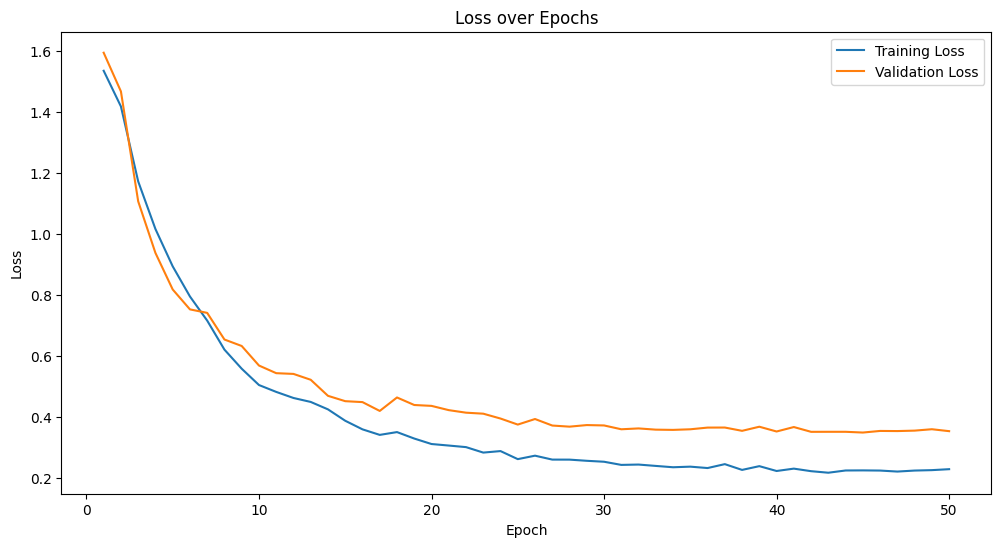

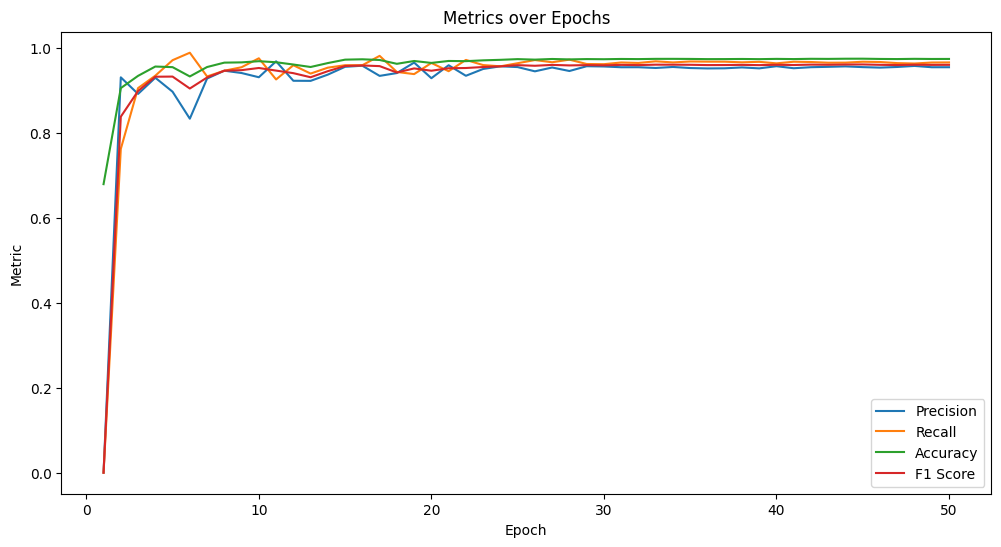

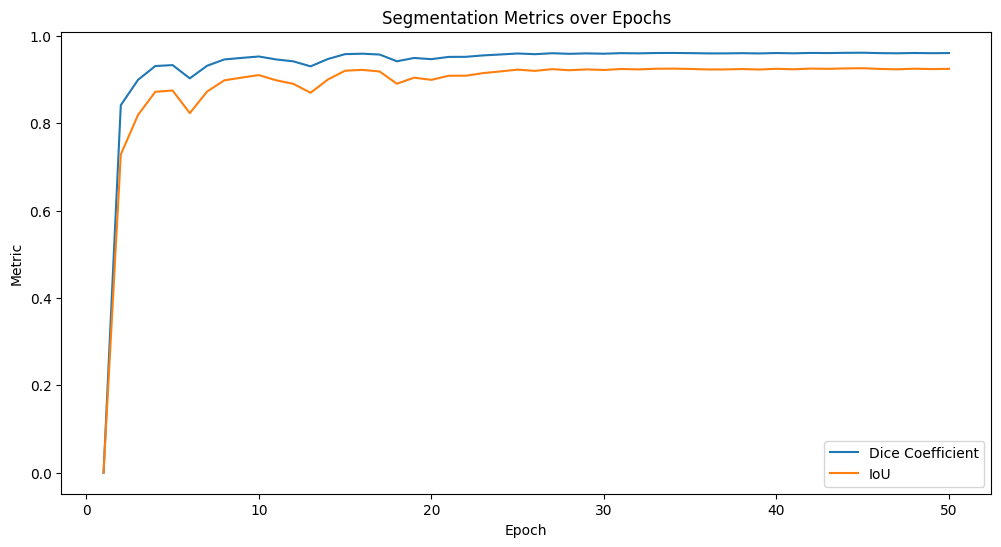

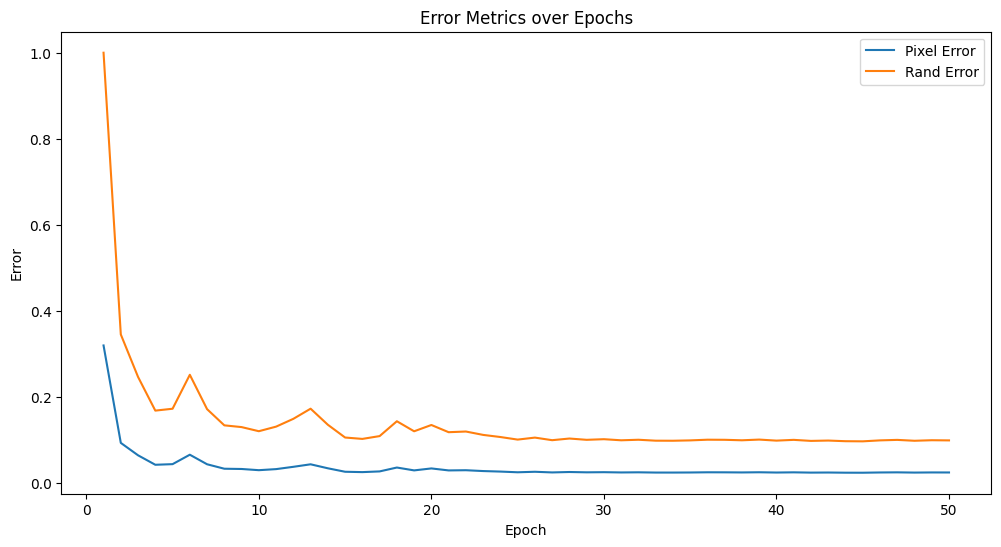

In [15]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



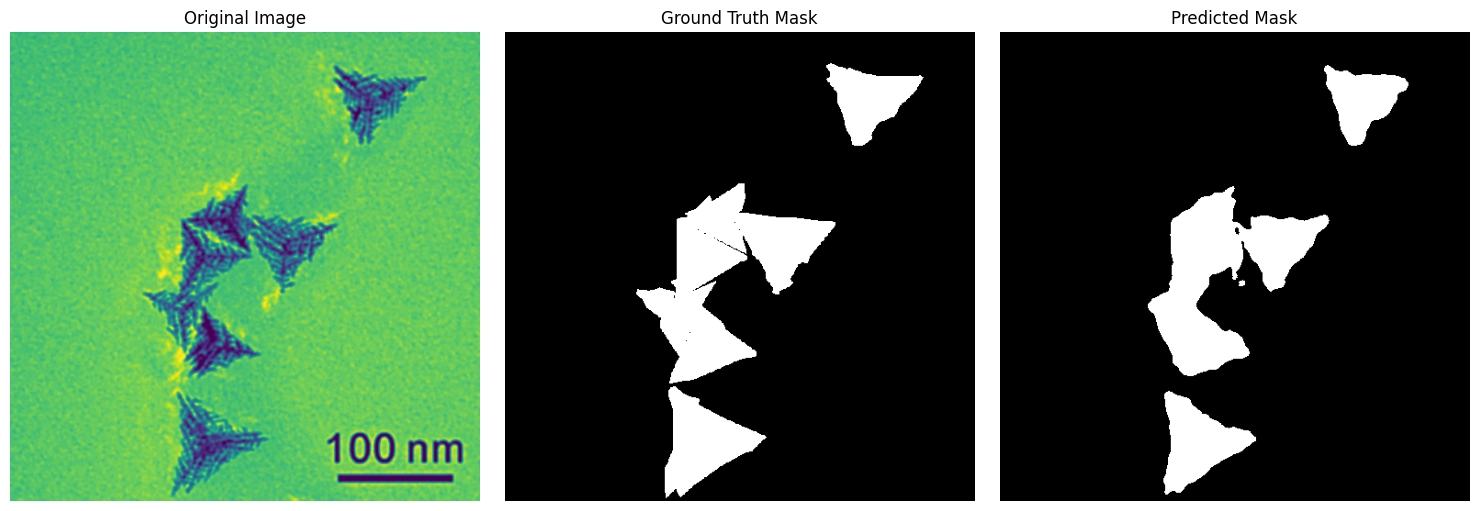

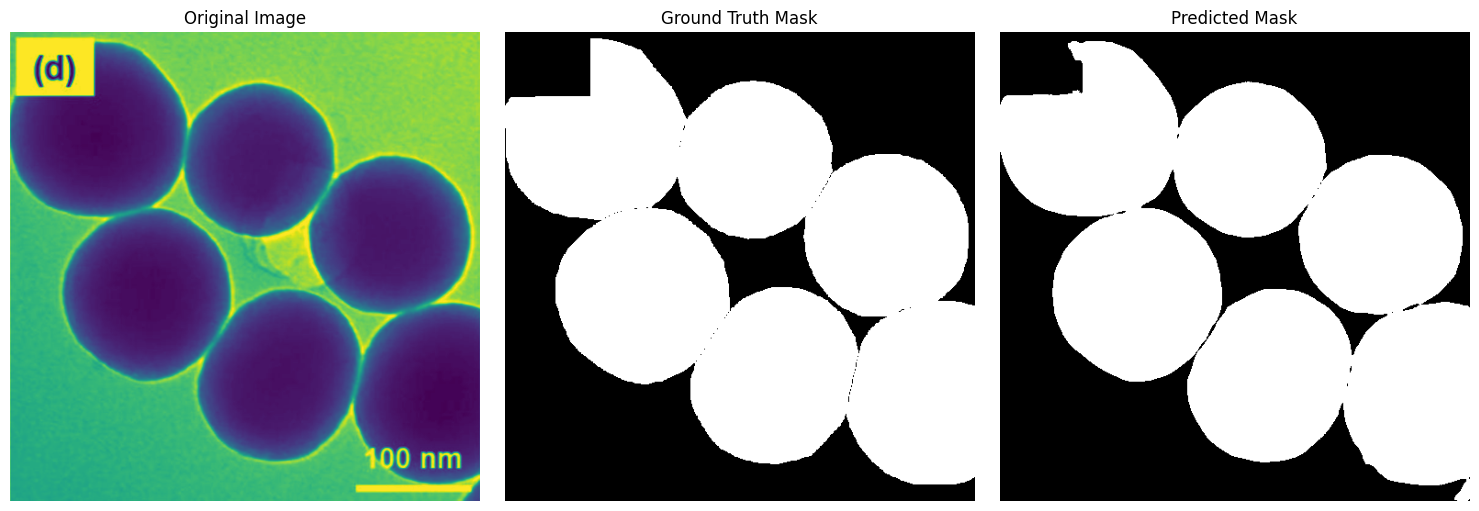

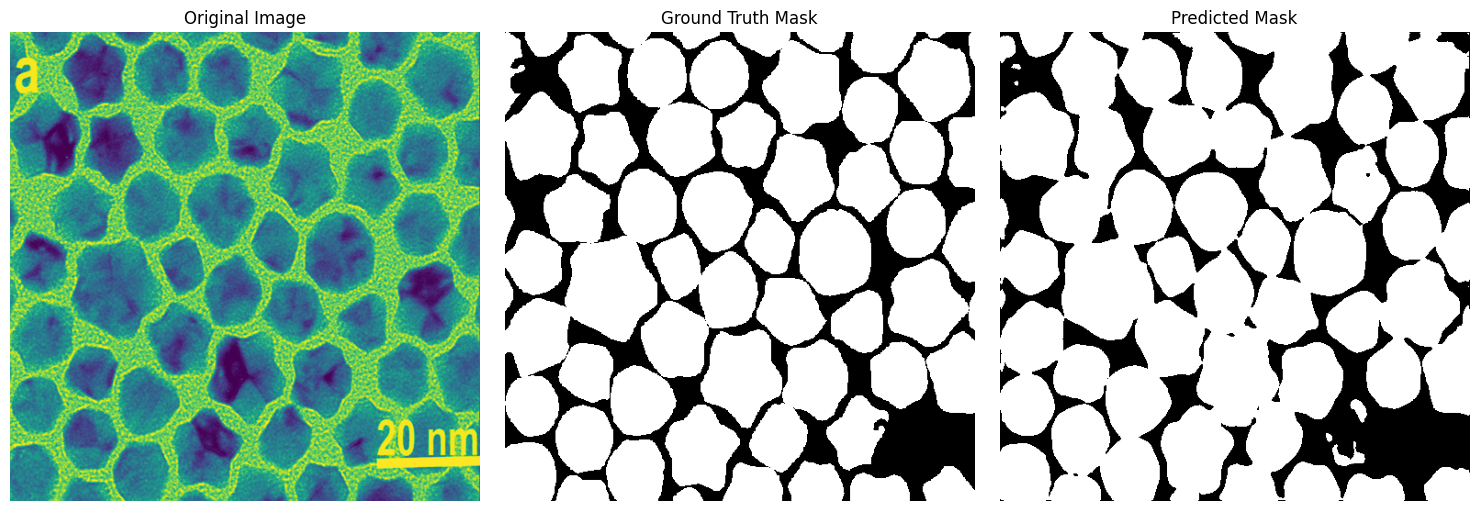

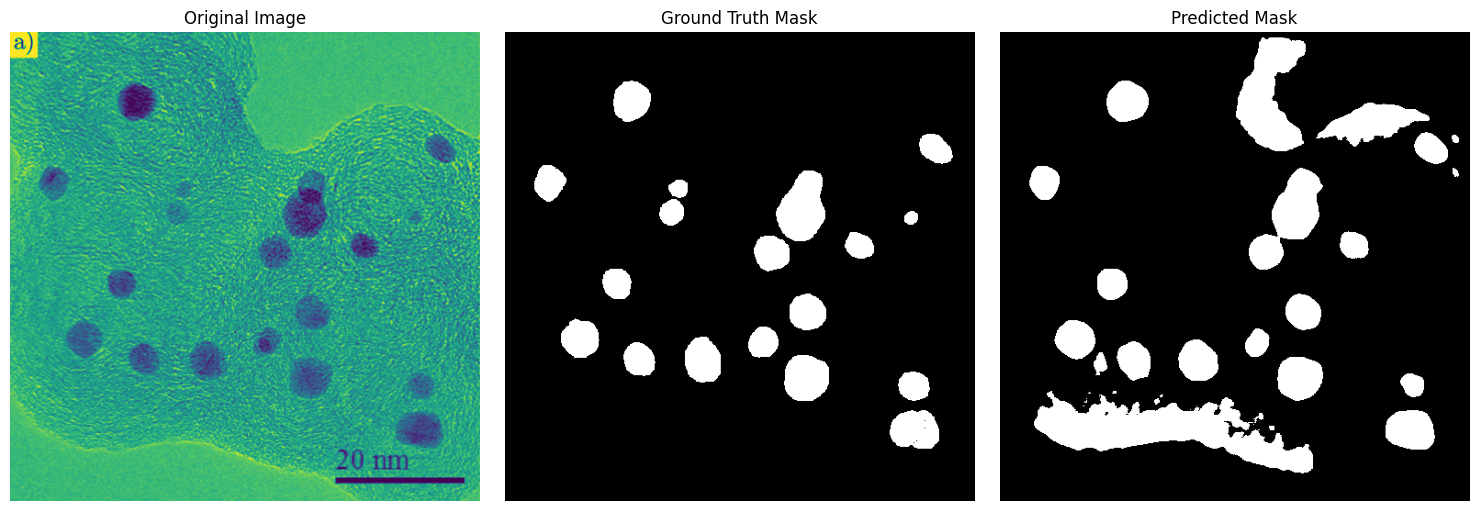

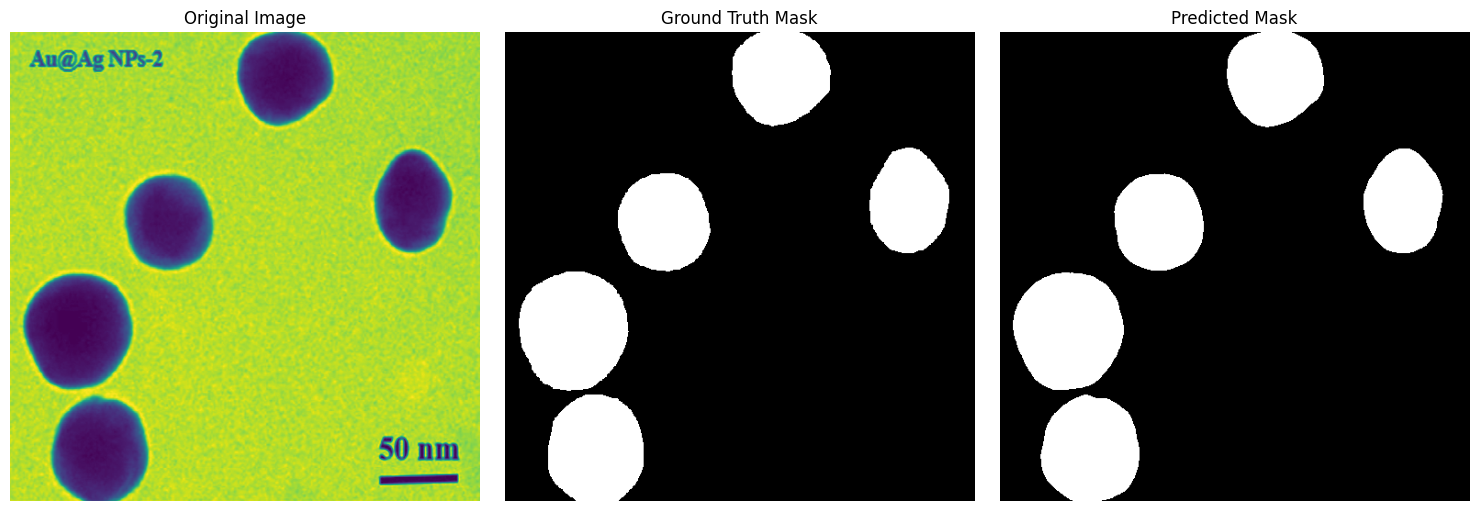

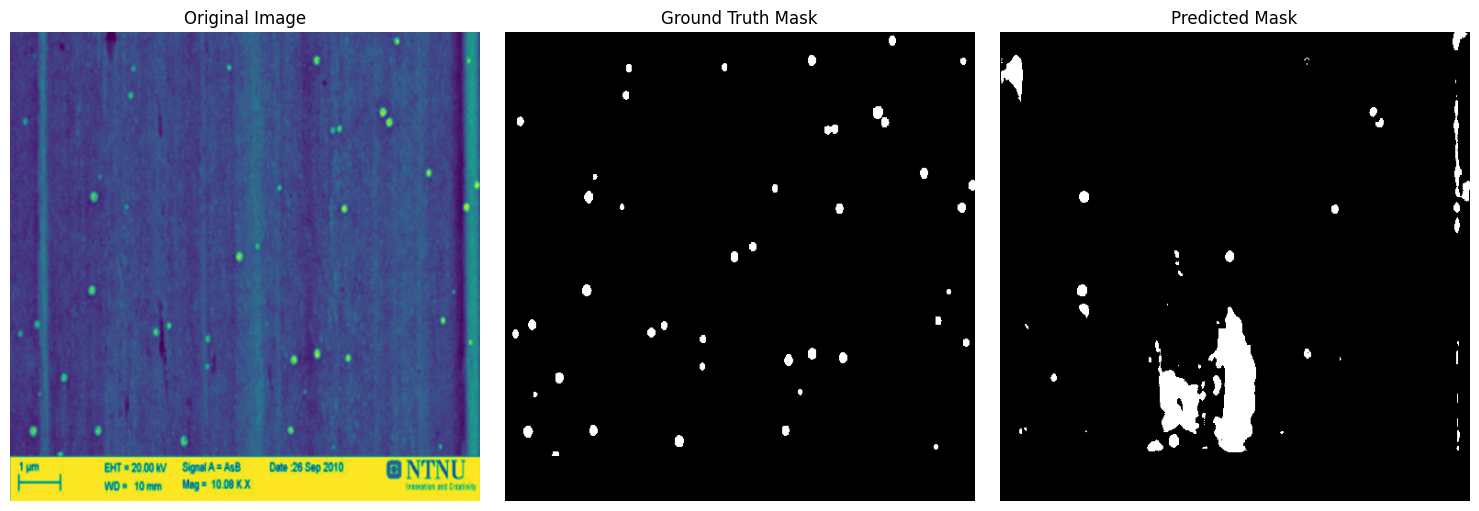

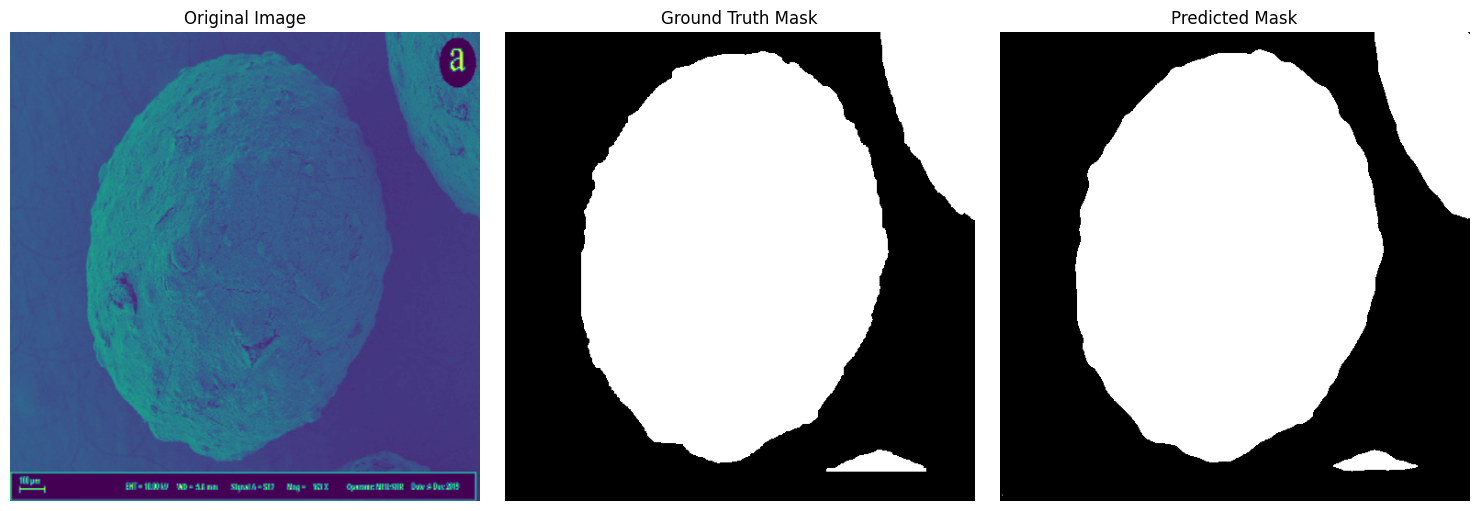

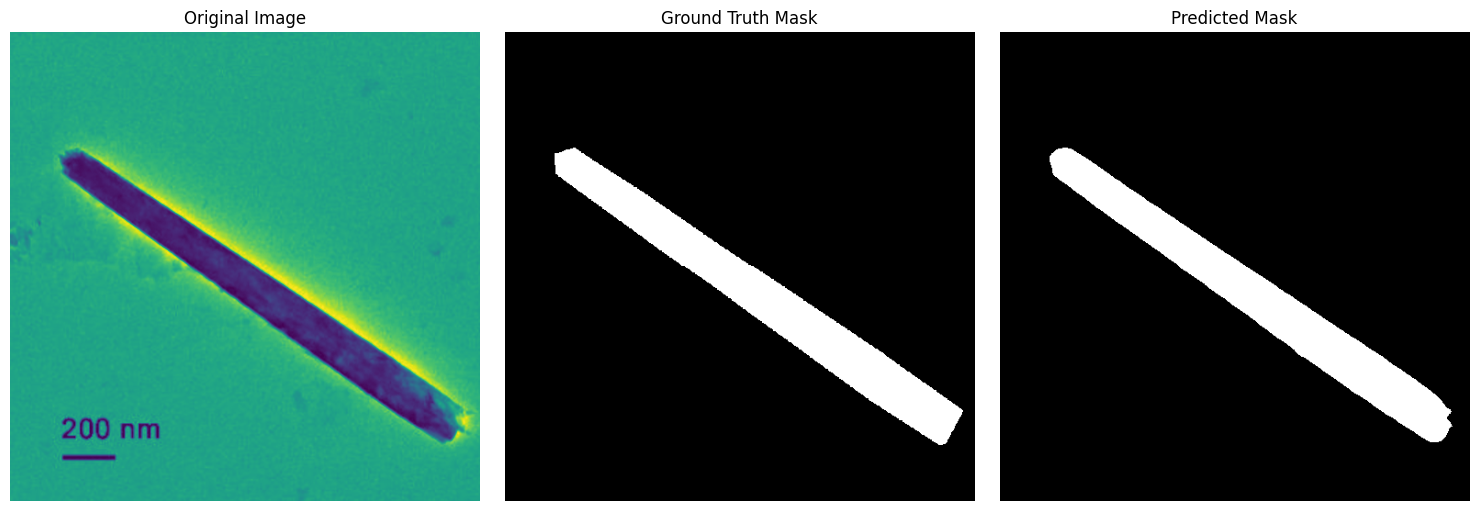

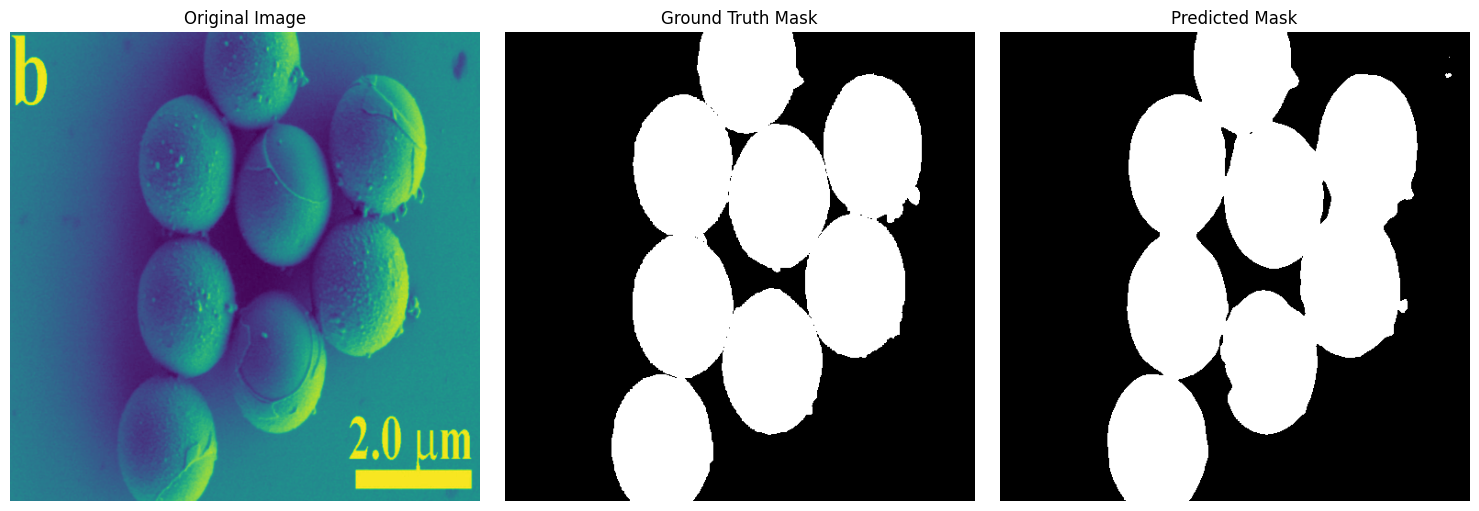

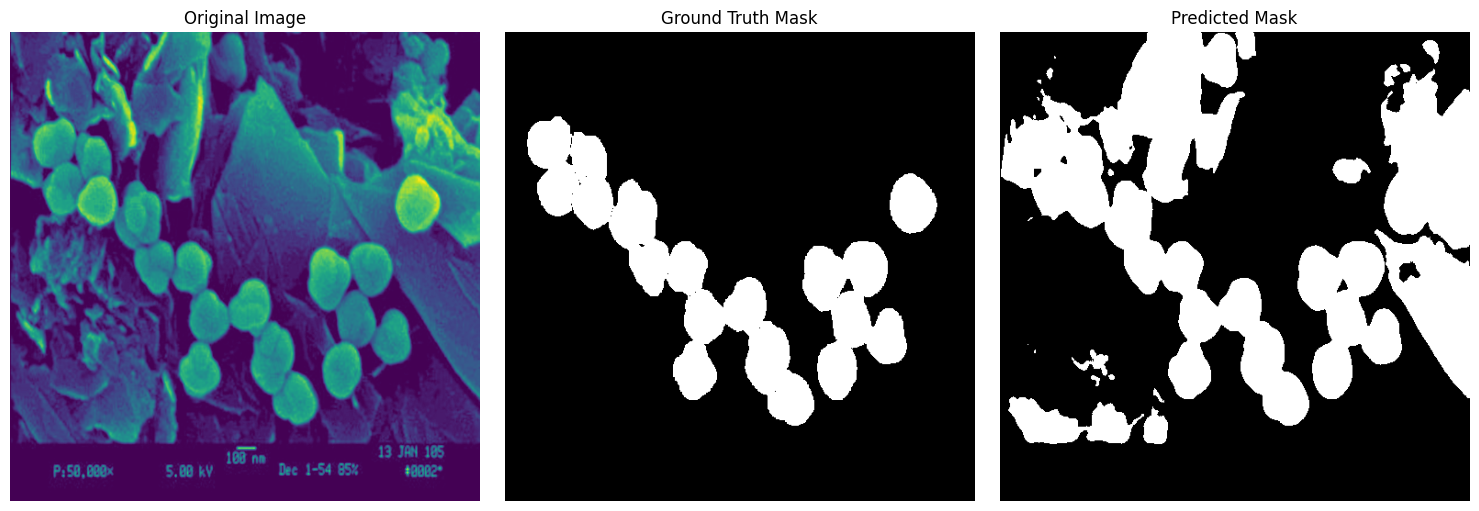

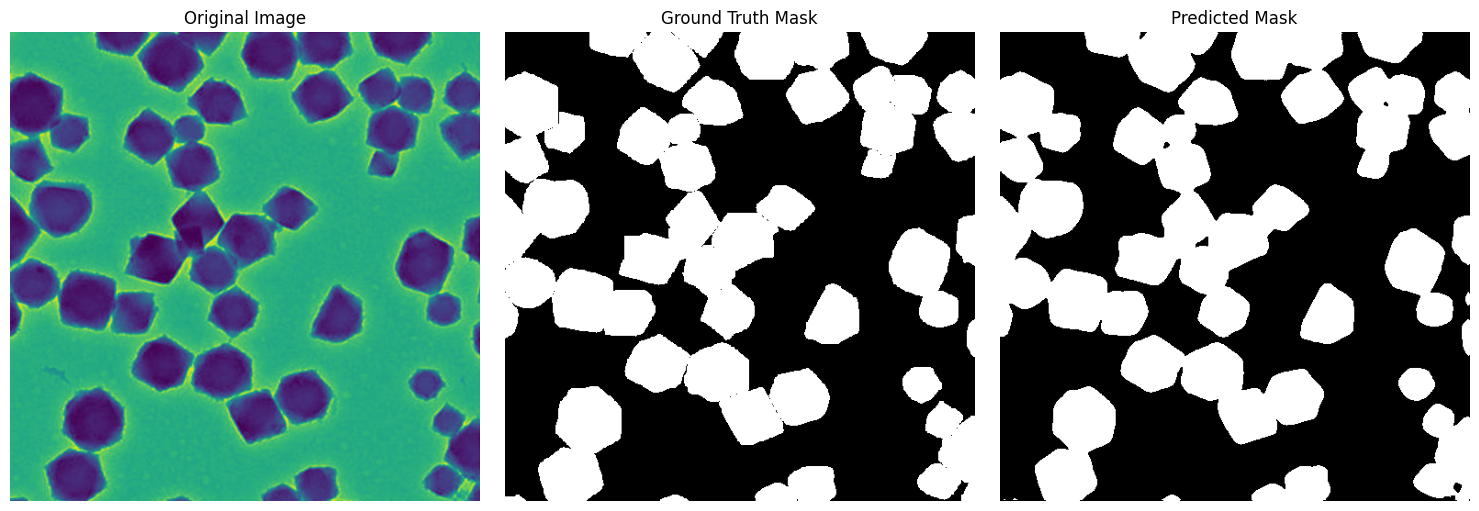

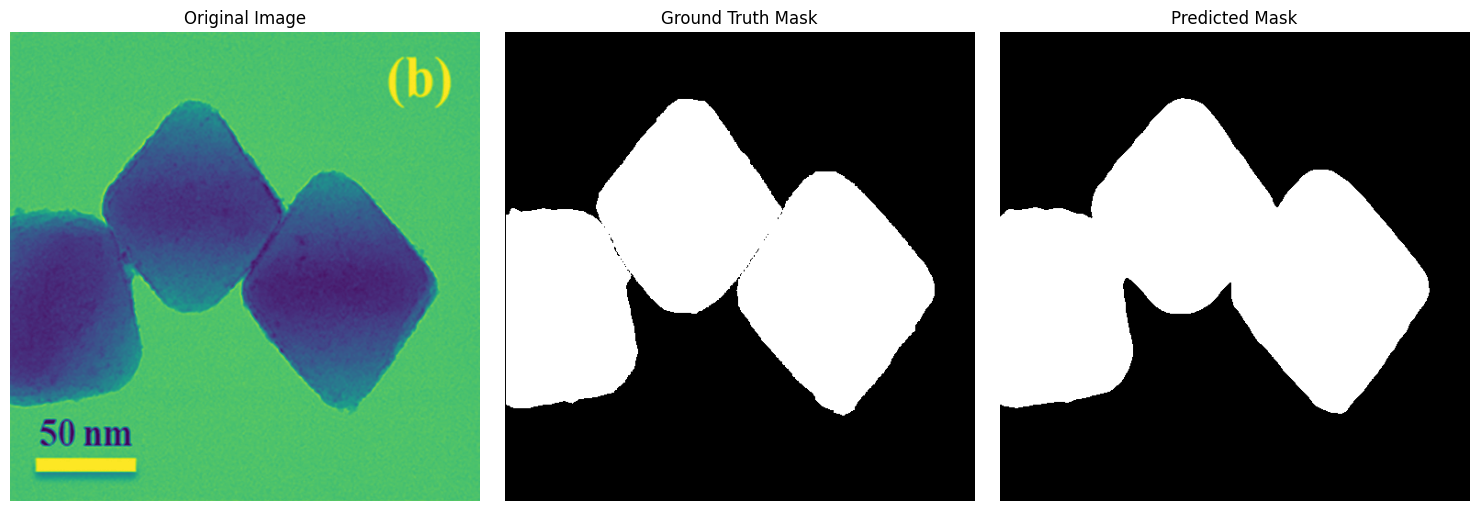

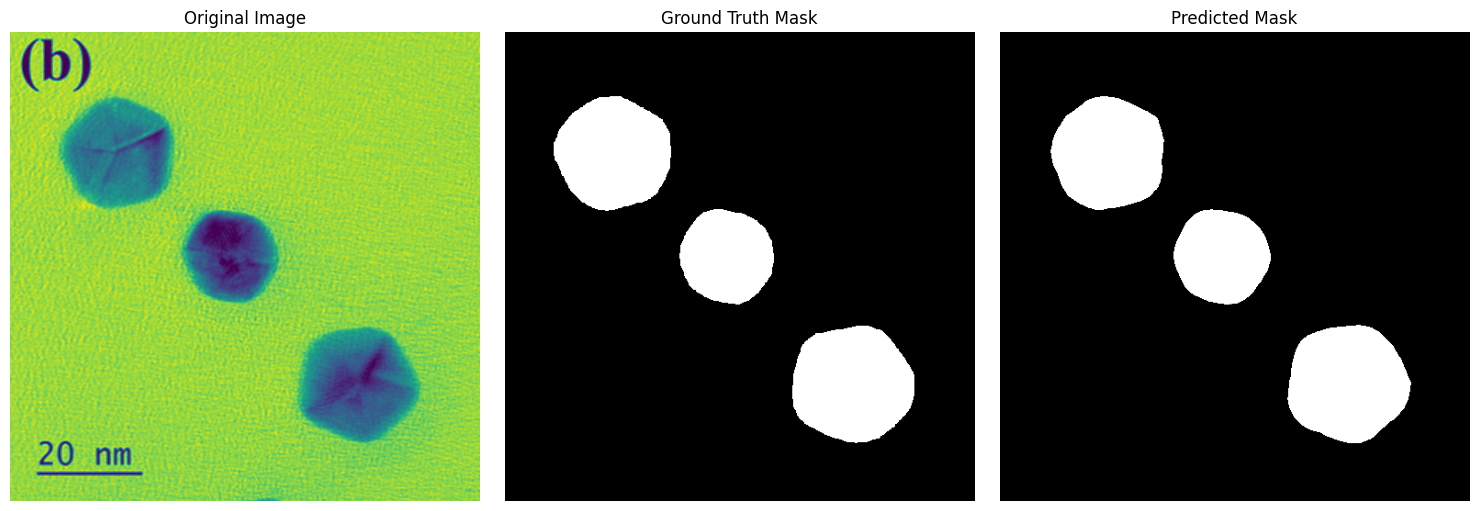

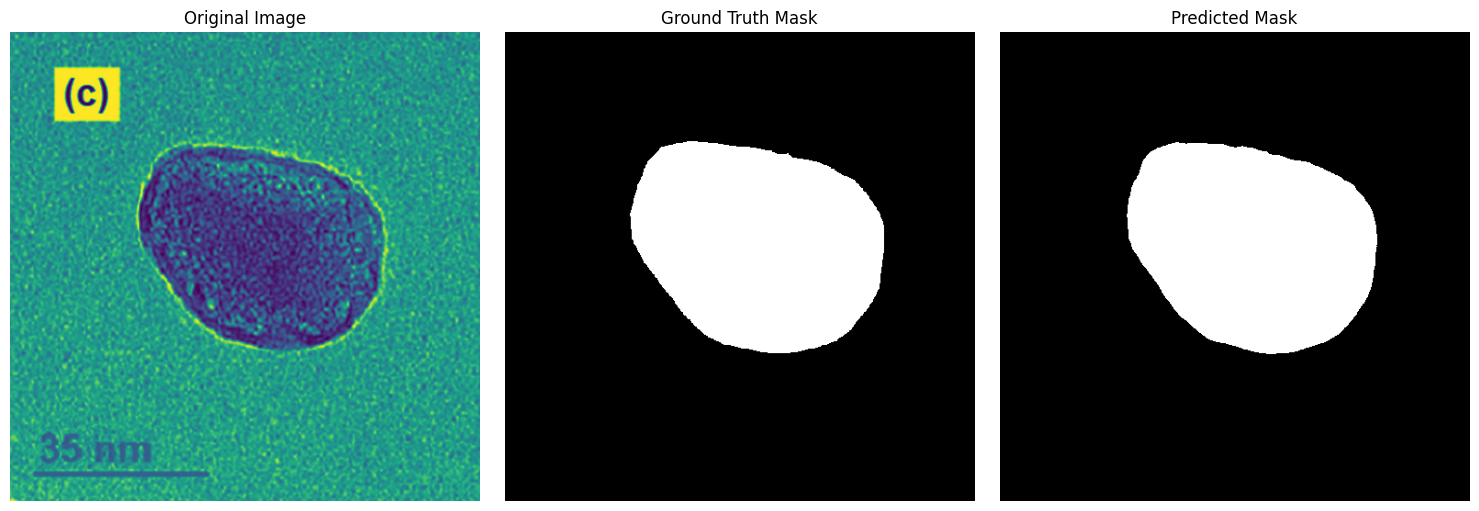

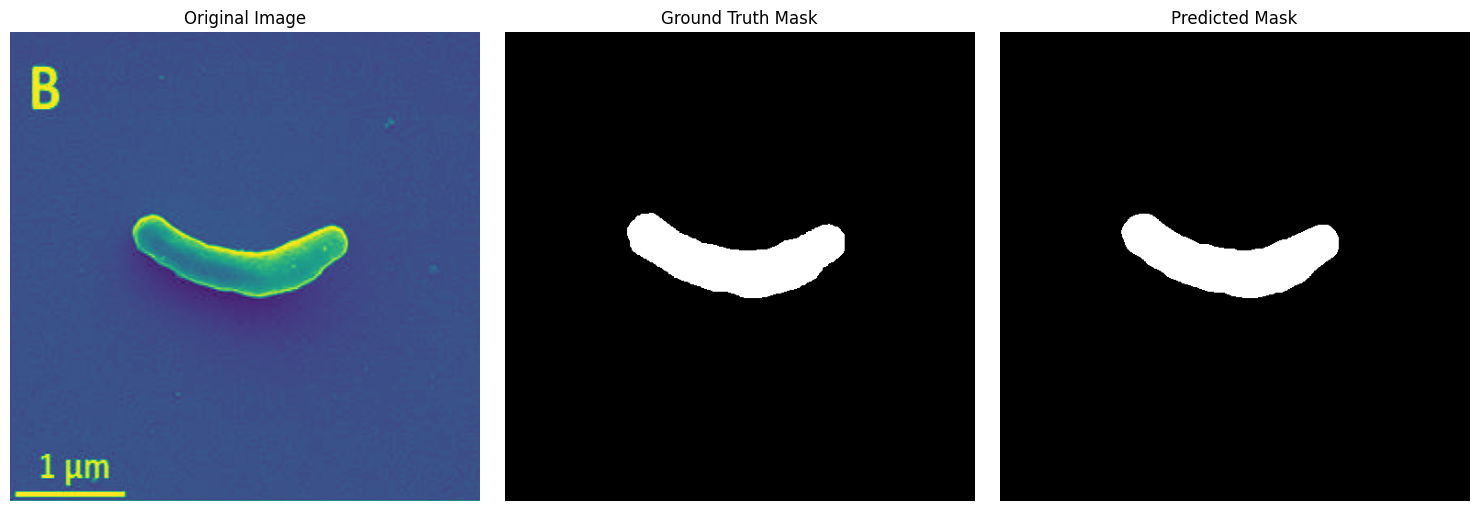

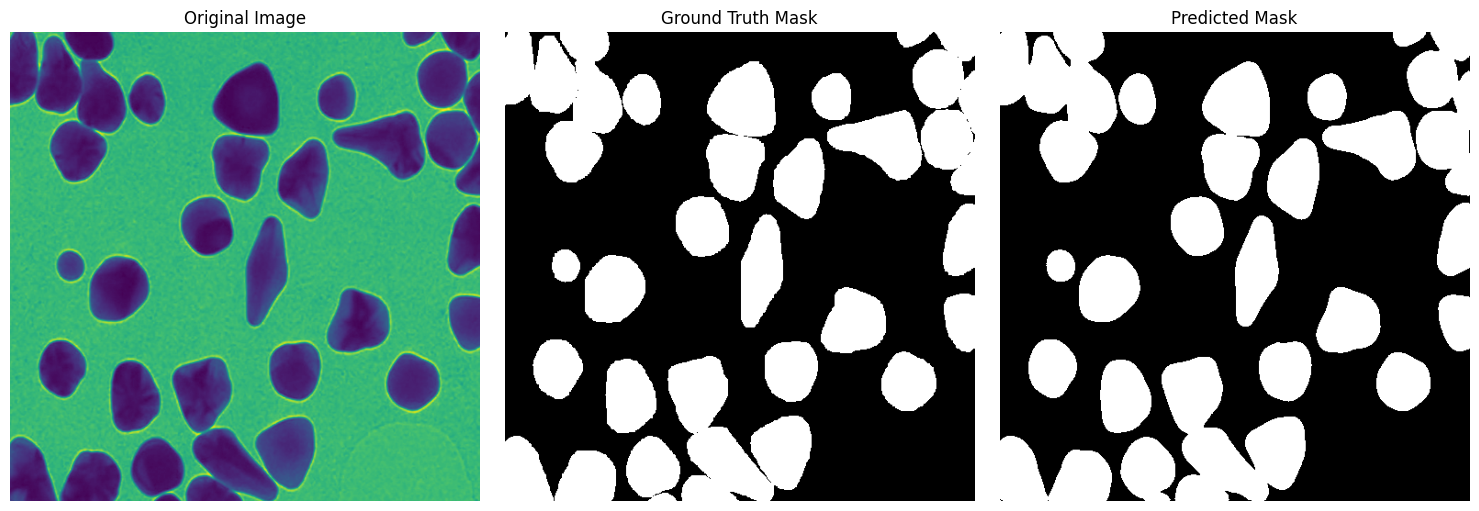

In [16]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy           iou  \
0       1    1.535493  1.594766   0.000000  0.000000  0.679864  8.234828e-13   
1       2    1.418288  1.467636   0.931492  0.762913  0.906137  7.285917e-01   
2       3    1.172314  1.106834   0.892412  0.906181  0.934991  8.191159e-01   
3       4    1.015932  0.937381   0.930562  0.935376  0.956967  8.719839e-01   
4       5    0.893442  0.817484   0.897633  0.971920  0.955527  8.749453e-01   
5       6    0.794438  0.752081   0.834061  0.989505  0.933617  8.231837e-01   
6       7    0.715173  0.740577   0.928684  0.933596  0.955790  8.724937e-01   
7       8    0.619878  0.653117   0.947170  0.947102  0.966154  8.982262e-01   
8       9    0.557287  0.631894   0.941663  0.955356  0.966761  9.044269e-01   
9      10    0.503720  0.567755   0.931738  0.976371  0.969536  9.102088e-01   
10     11    0.481137  0.542625   0.969237  0.926534  0.967067  8.983410e-01   
11     12    0.461188  0.540209   0.9234